# <span style="color:mediumvioletred"> **Data Wrangling**</span>
### **Proyecto de Ciencia de Datos**
- Aissa Berenice Gonzalez Fosado 752224
- Clara Paola Aguilar Casillas
- Daniela de la Torre Gallo


<img src="https://oci02.img.iteso.mx/Identidades-De-Instancia/ITESO/Logos%20ITESO/Logo-ITESO-Principal-Gris.png"  width="300">

Para esta seccion, aplicaremos nuestros conocimentos obtenidos del EDA y limpiaremos el dataset y lo adaptaremos a nuestras necesidades para el proyecto, para después exportarlo en datos procesados.

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/raw/apartments.csv", sep=";", encoding='cp1252')

df_clean = df.copy()

### **Datos Nulos y Duplicados**

In [125]:
# Textuales y categóricas
df_clean['pets_allowed'].fillna('unknown', inplace=True)
df_clean['amenities'].fillna('Not specified', inplace=True)
df_clean['address'].fillna('Not provided', inplace=True)

for col in ['state', 'cityname']:
    df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

# Numéricas
for col in ['bathrooms','bedrooms','latitude','longitude']:
    df_clean[col].fillna(df_clean[col].median(), inplace=True)


In [126]:
df_clean.isnull().sum().sort_values(ascending=False)

id               0
category         0
source           0
longitude        0
latitude         0
state            0
cityname         0
address          0
square_feet      0
price_type       0
price_display    0
price            0
pets_allowed     0
has_photo        0
fee              0
currency         0
bedrooms         0
bathrooms        0
amenities        0
body             0
title            0
time             0
dtype: int64

In [127]:
before = df_clean.shape[0]
df_clean.drop_duplicates(inplace=True)
after = df_clean.shape[0]
print(f"Registros eliminados por duplicados: {before - after}")

Registros eliminados por duplicados: 0


 Después llenamos los Nan, de acuerdo a lo que viene en cada variable por ejemplo unknown en algunas categorías, la moda para la ubicación y la media para `bathrooms`,  `bedrooms`,`latitude`,`longitude`. No hubo duplicados que necesitamos eliminar.

### **Casting**

In [128]:
df_clean['price'] = df_clean['price'].astype(int)
df_clean['bedrooms'] = df_clean['bedrooms'].astype(int)
df_clean['bathrooms'] = df_clean['bathrooms'].astype(float)

Corregimos el formato de variables que debian ser int, para su mejor manejo. Solo encontramos errores en estas 3 a partir del EDA.

### **Encoding**

In [129]:
# Encoding de variables categóricas
df_clean['pets_allowed'] = df_clean['pets_allowed'].map({'Yes': 1, 'No': 0})

# Variables categóricas nominales
from sklearn.preprocessing import LabelEncoder

le_city = LabelEncoder()
le_state = LabelEncoder()

df_clean['cityname'] = le_city.fit_transform(df_clean['cityname'].astype(str))
df_clean['state'] = le_state.fit_transform(df_clean['state'].astype(str))

print(df_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             10000 non-null  int64  
 1   category       10000 non-null  object 
 2   title          10000 non-null  object 
 3   body           10000 non-null  object 
 4   amenities      10000 non-null  object 
 5   bathrooms      10000 non-null  float64
 6   bedrooms       10000 non-null  int32  
 7   currency       10000 non-null  object 
 8   fee            10000 non-null  object 
 9   has_photo      10000 non-null  object 
 10  pets_allowed   0 non-null      float64
 11  price          10000 non-null  int32  
 12  price_display  10000 non-null  object 
 13  price_type     10000 non-null  object 
 14  square_feet    10000 non-null  int64  
 15  address        10000 non-null  object 
 16  cityname       10000 non-null  int32  
 17  state          10000 non-null  int32  
 18  latitud

Utilizamos Encoding para representar variables categoricas, con mapeo y label encoder.

### **Outliers**

In [130]:
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    return data[(data[column] >= lower) & (data[column] <= upper)]

df_clean = remove_outliers_iqr(df_clean, 'price')
df_clean = remove_outliers_iqr(df_clean, 'square_feet')

Usamos el método del rango intercuartil (IQR) para filtrar precios y áreas excesivas. Agregamos debajo las graficas para comparar los datos.

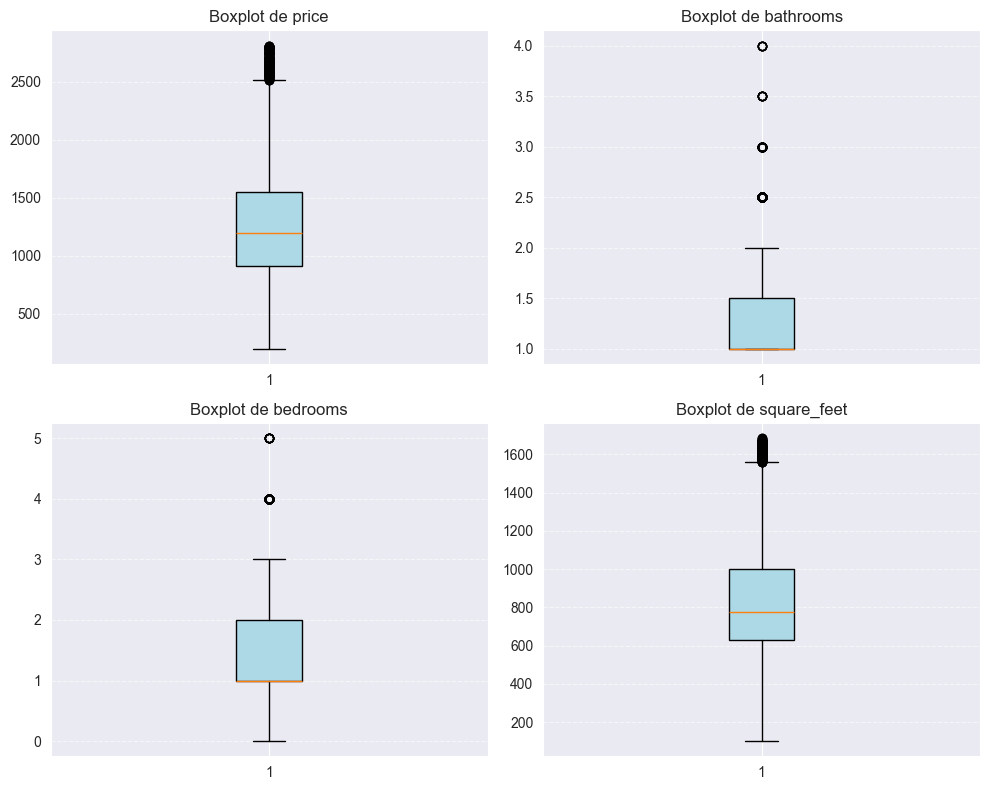

In [131]:
fig, axes = plt.subplots(2, 2, figsize=(10,8))
axes = axes.ravel()
cols = ['price', 'bathrooms', 'bedrooms', 'square_feet']

for i, col in enumerate(cols):
    axes[i].boxplot(df_clean[col].dropna(), patch_artist=True, boxprops=dict(facecolor='lightblue'))
    axes[i].set_title(f'Boxplot de {col}')
    axes[i].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [132]:
print("Precio mínimo:", df_clean['price'].min())
print("Precio máximo:", df_clean['price'].max())
print("Área mínima:", df_clean['square_feet'].min())
print("Área máxima:", df_clean['square_feet'].max())

Precio mínimo: 200
Precio máximo: 2810
Área mínima: 101
Área máxima: 1685


Los datos resultantes y las escalas de los boxplots, son mucho más razonables que antes del tratamiento de los datos con cuartiles.

### **Distribuciones después de la Limpieza de Datos**

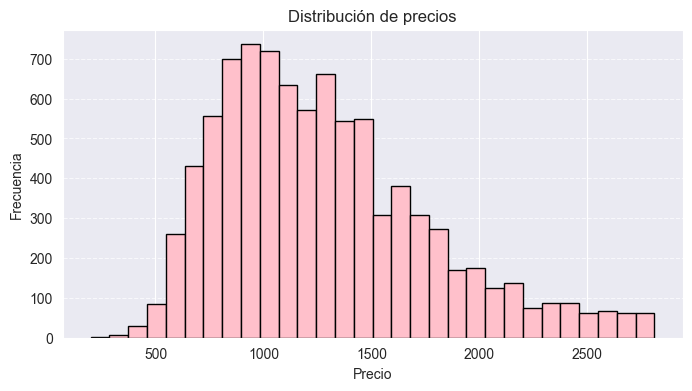

In [133]:
plt.figure(figsize=(8,4))
plt.hist(df_clean['price'], bins=30, color='pink', edgecolor='black')
plt.title('Distribución de precios')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

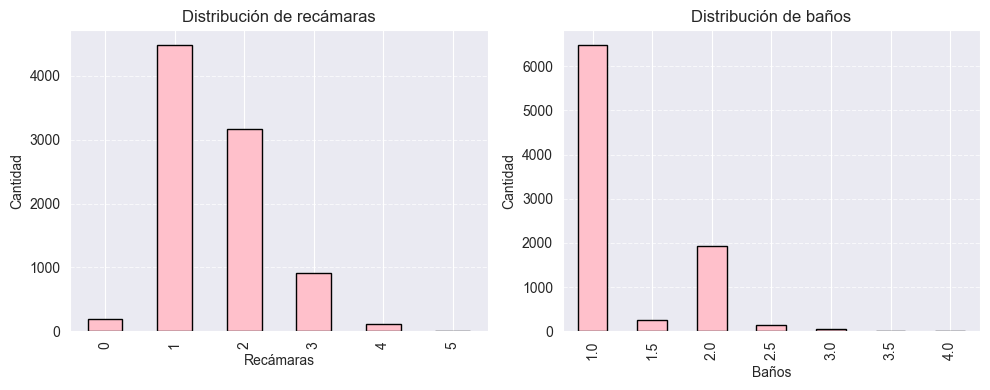

In [134]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

df_clean['bedrooms'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='pink', edgecolor='black')
axes[0].set_title('Distribución de recámaras')
axes[0].set_xlabel('Recámaras')
axes[0].set_ylabel('Cantidad')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

df_clean['bathrooms'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='pink', edgecolor='black')
axes[1].set_title('Distribución de baños')
axes[1].set_xlabel('Baños')
axes[1].set_ylabel('Cantidad')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

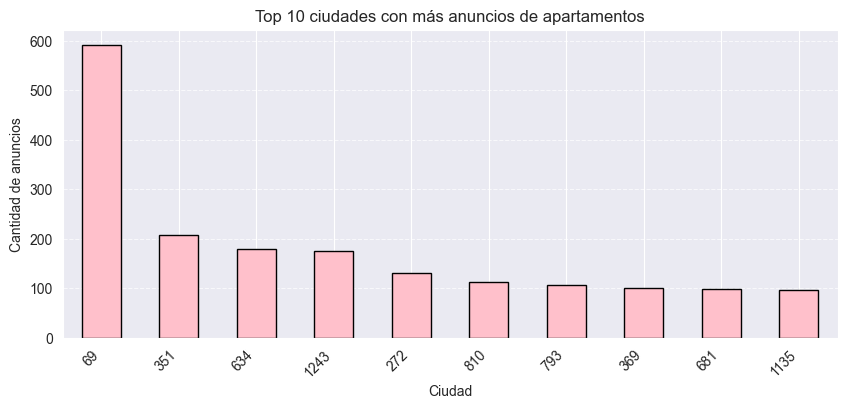

In [135]:
plt.figure(figsize=(10,4))
df_clean['cityname'].value_counts().head(10).plot(kind='bar', color='pink', edgecolor='black')
plt.title('Top 10 ciudades con más anuncios de apartamentos')
plt.xlabel('Ciudad')
plt.ylabel('Cantidad de anuncios')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

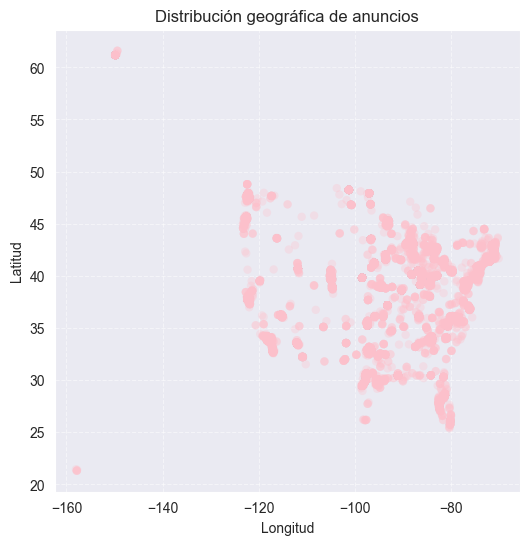

In [136]:
plt.figure(figsize=(6,6))
plt.scatter(df_clean['longitude'], df_clean['latitude'], alpha=0.3, color='pink', edgecolor='none')
plt.title('Distribución geográfica de anuncios')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Ahora que tenemos las nuevas distribuciones, exportaremos este df, para continuar trabajando con el en nuestro proyecto.

### **Seleccion de Variables**

In [137]:
df_clean['amenities_count'] = df['amenities'].apply(lambda x: len(str(x).split(',')) if pd.notnull(x) else 0)

cols_to_drop = [
    'id', 'time', 'address', 'amenities',
    'title', 'body', 'currency', 'fee',
    'price_display', 'price_type', 'source'
]

df_clean.drop(columns=cols_to_drop, inplace=True, errors='ignore')

print("Columnas eliminadas:", cols_to_drop)
print("\n Columnas Finales:")
print(df_clean.dtypes)

Columnas eliminadas: ['id', 'time', 'address', 'amenities', 'title', 'body', 'currency', 'fee', 'price_display', 'price_type', 'source']

 Columnas Finales:
category            object
bathrooms          float64
bedrooms             int32
has_photo           object
pets_allowed       float64
price                int32
square_feet          int64
cityname             int32
state                int32
latitude           float64
longitude          float64
amenities_count      int64
dtype: object


Con el Heatmap, llegamos a las siguientes conclusiones, por lo que dropearemos algunas columnas:

`id` correlación perfecta con time (1.0), redundante.

`time` solo representa orden temporal, sin relación con precios.

`address` texto no estructurado, no utilizable sin NLP.

`amenities` texto libre con alta cardinalidad (sustuimos este por amenities_count).

`price_display`, `price_type`, `currency`, `fee`, `source`, `title`, `body` → texto repetitivo o redundante del precio.

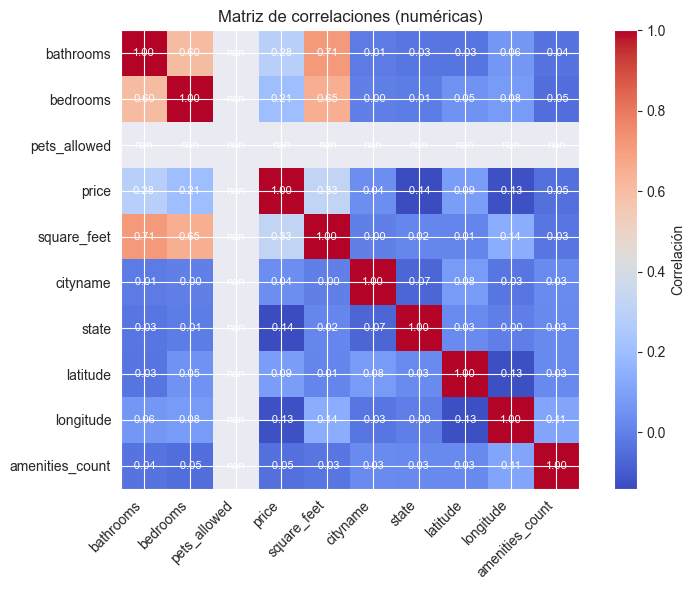

In [138]:
corr = df_clean.corr(numeric_only=True)

plt.figure(figsize=(8,6))
im = plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlación')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title('Matriz de correlaciones (numéricas)')

for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}",
                 ha="center", va="center", color="white", fontsize=8)

plt.tight_layout()
plt.show()

El mapa se ve ahora mas limpio, con mayores correlaciones. por lo que procederemos a guardar el df nuevo en processed.

In [139]:
df_clean.to_csv('../data/processed/df_clean.csv', index=False)

## **Conclusiones de Data Wrangling**

Our dataset is now:
- Free of missing values ✅
- Cleaned of extreme outliers ✅
- Ready for feature engineering and modeling 🚀
